In [ ]:
# from google.colab import drive
# drive.mount('drive')

In [ ]:
# !pip install -q torch scikit-learn pandas tqdm

## Import libraries

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import re
from collections import Counter
from itertools import chain
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Load data

In [ ]:
train_df = pd.read_csv("data/train_data.csv")
val_df = pd.read_csv("data/val_data.csv")
test_df = pd.read_csv("data/test_data.csv")

In [ ]:
def tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

tokenized = train_df['text'].apply(tokenize)
all_tokens = list(chain.from_iterable(tokenized))
vocab_counter = Counter(all_tokens)
vocab = {'<PAD>': 0, '<UNK>': 1}
for word, count in vocab_counter.items():
    if count >= 2:
        vocab[word] = len(vocab)

## Encoding

In [ ]:
def encode(text, vocab):
    return [vocab.get(word, vocab['<UNK>']) for word in tokenize(text)]

## Dataset class

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.encoded = [torch.tensor(encode(t, vocab)) for t in texts]
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.encoded[idx], self.labels[idx]

def collate_fn(batch):
    texts, labels = zip(*batch)
    padded = pad_sequence(texts, batch_first=True, padding_value=vocab['<PAD>'])
    return padded, torch.tensor(labels)


## DataLoaders

In [ ]:
train_ds = TextDataset(train_df['text'], train_df['label'])
val_ds = TextDataset(val_df['text'], val_df['label'])
test_ds = TextDataset(test_df['text'], test_df['label'])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)

## LSTM

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
            x = self.embedding(x)
            _, (h_n, _) = self.lstm(x)
            return self.fc(h_n.squeeze(0))


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(
    vocab_size=len(vocab), embed_dim=100, hidden_dim=128,
    output_dim=len(train_df['label'].unique())
    ).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(5):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for x_batch, y_batch in progress_bar:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1))
    print(f"Epoch {epoch+1} Average Loss: {total_loss / len(train_loader):.4f}")

## Evaluation

In [ ]:
all_preds, all_labels = [], []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader, desc="Evaluating on Test Set"):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch)
        preds = torch.argmax(output, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

print("\n--- Validation Metrics ---")
print(classification_report(all_labels, all_preds, digits=4))

Evaluating on Test Set:   0%|          | 0/165 [00:00<?, ?it/s]


--- Validation Metrics ---
              precision    recall  f1-score   support

           0     0.8296    0.8299    0.8298      4187
           1     0.5446    0.4574    0.4972      1255
           2     0.8478    0.8812    0.8642      5057

    accuracy                         0.8101     10499
   macro avg     0.7406    0.7228    0.7304     10499
weighted avg     0.8043    0.8101    0.8066     10499


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Test Prec: {precision:.3f} | Test Rec: {recall:.3f} | Test F1: {f1:.3f}")


Test Prec: 0.741 | Test Rec: 0.723 | Test F1: 0.730


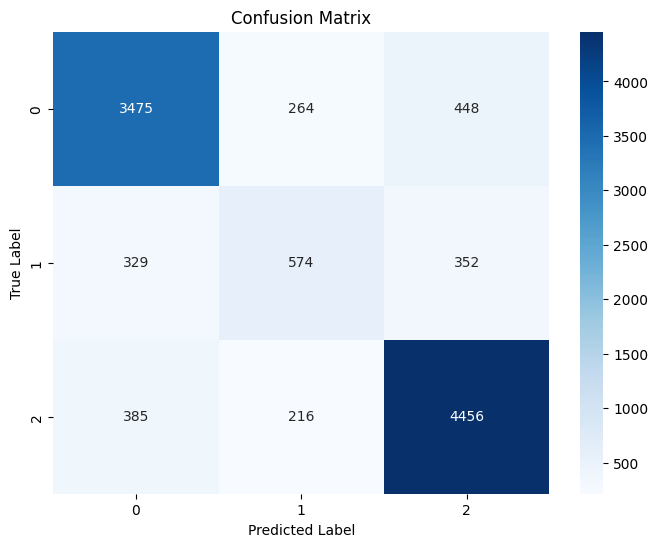

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
labels_sorted = sorted(train_df['label'].unique())  # optional: ensure consistent label order

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()